In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax
####################################### Plotting Function
def set_label(ax, xpcent, ypcent, text, fontsize=12, color='k'):
    
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x2 = xpcent/100.
    x1 = 1.-x2
    y2 = ypcent/100.
    y1 = 1.-y2
    x0 = x1*Xlm[0]+x2*Xlm[1]
    y0 = y1*Ylm[0]+y2*Ylm[1]
    ax.text(x0,y0, text, fontsize=fontsize, color=color)



In [3]:
def getMagLim(slope, zp, Mi_lim = -17, band = 'i'):
    
    if band=='u':
        alpha = 2.68
        beta = 1.58
        w_ = (zp-beta-Mi_lim)/(alpha-slope)
        Mlim = slope * w_ + zp
        return Mlim
    elif band=='g':
        alpha = 0.84
        beta = 0.64
        w_ = (zp-beta-Mi_lim)/(alpha-slope)
        Mlim = slope * w_ + zp
        return Mlim
    elif band=='r':
        alpha = 0.27
        beta = 0.23
        w_ = (zp-beta-Mi_lim)/(alpha-slope)
        Mlim = slope * w_ + zp
        return Mlim
    elif band=='i':
        Mlim = Mi_lim
        return Mlim
    elif band=='z':
        alpha = 0.25
        beta = 0.12
        w_ = (zp+beta-Mi_lim)/(-alpha-slope)
        Mlim = slope * w_ + zp
        return Mlim    
    elif band=='w1':
        alpha = 1.18
        beta = -0.47
        w_ = (zp+beta-Mi_lim)/(-alpha-slope)
        Mlim = slope * w_ + zp
        return Mlim  
    elif band=='w2':
        alpha = 1.32
        beta = -1.04
        w_ = (zp+beta-Mi_lim)/(-alpha-slope)
        Mlim = slope * w_ + zp
        return Mlim      

In [4]:
band = 'i'
param = 'a'
## Luminosity function parameters
alpha = -1
Ms = -22

## TF realtion parameters
slope = -8.34
zp = -20.80-0.04
rms = 0.49

A = 0

Mlim = getMagLim(slope, zp, band = band)
print band
print "Mag. Limit:", '%.2f'%Mlim

i
Mag. Limit: -17.00


In [5]:
SZ0 = [slope, zp]

SZ1 = getSimuSZ(SZ0,
                mag_scatter=rms, 
                Mlim = Mlim, 
                Simul_size = 100000,
                Ms=Ms, alpha=alpha, verbose=False)

print SZ0, SZ1, iterate(SZ1,
                mag_scatter=rms, 
                Mlim = Mlim, 
                Simul_size = 100000,
                Ms=Ms, alpha=alpha)

# of iter: 10  Cost:  0.0325 [-8.60655141983981, -20.957971802406473]
# of iter: 20  Cost:  0.0173 [-8.478207345762552, -20.946507871120758]
# of iter: 30  Cost:  0.0049 [-8.36381092148349, -20.922155127748766]
# of iter: 40  Cost:  0.0015 [-8.34001401000326, -20.87162269860986]
[-8.34, -20.84] [-7.961281333098579, -20.72135746616632] [-8.340000017232686, -20.84130924810064]


In [6]:
slope_1 = SZ1[0]
zp_1 = SZ1[1]
print slope_1, zp_1

-7.961281333098579 -20.72135746616632


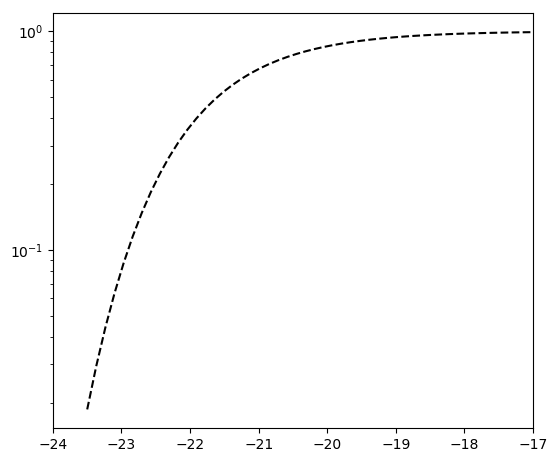

In [7]:
fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)
ax.set_xlim([-24,-17])

M = np.linspace(-23.5,-17,50)
N = LFfunction(M, Ms, alpha)
ax.plot(M,N,'k--')

ax.set_yscale("log", nonposy='clip')

0.48810635216622034


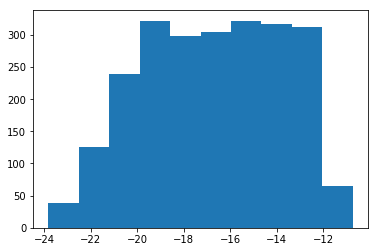

In [8]:
np.random.seed(0)

size = 3000
randMGAG = np.random.uniform(low=-24, high=-12, size=size)

randU = np.random.uniform(low=0, high=1, size=size)

randLfunct = LFfunction(randMGAG, Ms, alpha)

indx, = np.where(randU<randLfunct)

simulMag  = randMGAG[indx]
simulWimx = (simulMag-zp_1)/slope_1 + 2.5
N = len(simulMag)
scatterMAG = np.random.normal(0, rms, N)
simulMag += scatterMAG


# print randMGAG
# print randU
plt.hist(simulMag)
print np.std(scatterMAG)

0.47223520725407975


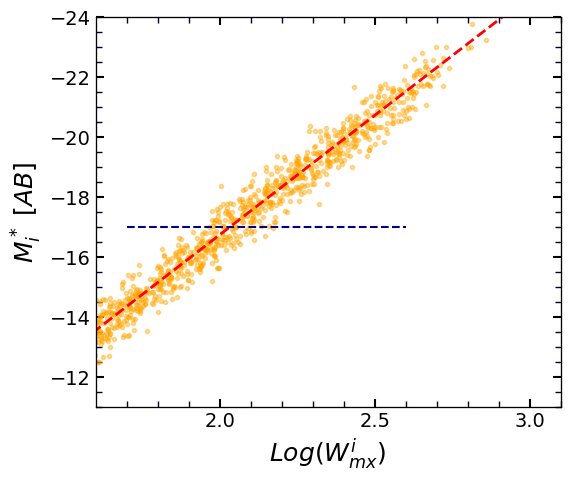

In [9]:
fig, ax = makeFig(band=band, xLim = (1.6,3.1), yLim = (-11,-24), MAGabs=True)
dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}

x = np.linspace(-5,5,50)
y = slope_1*(x-2.5)+zp_1
 
    
bias, simulMag, simulWimx = simulFiled_Mscatter(slope_1, zp_1, Ms, alpha, 
               mag_scatter=rms, size=1000, seed=0)
ax.plot(simulWimx, simulMag, '.', color=dye[band], alpha=0.4)
print np.std(simulMag-(slope_1*(simulWimx-2.5)+zp_1))


ax.plot(x,y, 'r--', lw=2) 

x = np.linspace(1.7,2.6,20)
if band=='u':
    ax.plot(x,-17+(2.68*(x-2.5)+1.58),'--', lw=1.5, color='navy')  
if band=='g':
    ax.plot(x,-17+(0.84*(x-2.5)+0.64),'--', lw=1.5, color='navy')  
if band=='r':
    ax.plot(x,-17+(0.27*(x-2.5)+0.23),'--', lw=1.5, color='navy')  
if band=='i':
    ax.plot(x,-17+(0*(x-2.5)+0),'--', lw=1.5, color='navy')      
if band=='z':
    ax.plot(x,-17-(0.25*(x-2.5)+0.12),'--', lw=1.5, color='navy')          
if band=='w1':
    ax.plot(x,-17-(1.18*(x-2.5)-0.47),'--', lw=1.5, color='navy')
if band=='w2':
    ax.plot(x,-17-(1.32*(x-2.5)-1.04),'--', lw=1.5, color='navy') 

In [10]:
n_simul = 100
M0_C = np.arange(Mlim,Mlim-5.5,-0.5)


#########################################################


n_mag = len(M0_C)
outputs = np.zeros(n_mag*n_simul)
outputs = outputs.reshape(n_simul, n_mag)
for i in range(n_simul):
    bias, simulMag, simulWimx = simulFiled_Mscatter(slope_1, zp_1, Ms, alpha, 
               mag_scatter=rms, size=10000, seed=i)
    outputs[i] = simulCluster(M0_C, slope_1, zp_1, simulMag, simulWimx)
#     if i%10==0:
#         print i
bias_CM = np.median(outputs, 0)
bias_err_CM = np.std(outputs, 0)



n_mag = len(M0_C)
outputs = np.zeros(n_mag*n_simul)
outputs = outputs.reshape(n_simul, n_mag)
for i in range(n_simul):
    bias, simulMag, simulWimx = simulFiled_Mscatter(slope_1, zp_1, Ms, alpha, 
               mag_scatter=rms, size=10000, seed=i)
    outputs[i] = simulCluster(M0_C, slope_1, zp_1, simulMag, simulWimx, cut_alpha=A)
#     if i%10==0:
#         print i
bias_CM0 = np.median(outputs, 0)
bias_err_CM0 = np.std(outputs, 0)



In [11]:
def add2Dict(myDict, code, band, param, DM):
    
    if not code in myDict:
        myDict[code]={}
    if not band in myDict[code]:
        myDict[code][band]={}
    if not param in myDict[code][band]:
        myDict[code][band][param]={}
    myDict[code][band][param] = DM
##############################################   
table   = np.genfromtxt('cluster_code_Mlimit_revised.csv' , delimiter=',', 
                        filling_values=0, names=True, dtype=None, encoding=None)

mag_lims = table[band]
code = table['Code']  
##############################################
table   = np.genfromtxt('cluster_DM_code.csv' , delimiter=',', 
                        filling_values=0, names=True, dtype=None, encoding=None)
DM_band = table['band']
DM_param = table['param']
DM_code = table['Code']
DM = table['DM']
##############################################
    
DM_Dict = {}    
for i, myCode in enumerate(DM_code):
    add2Dict(DM_Dict, myCode.strip(), DM_band[i].strip(), DM_param[i].strip(), np.float(DM[i]))  

In [12]:
for i, cc in enumerate(code):
    cc = cc.strip()
    if mag_lims[i]>0:
        if param in DM_Dict[cc][band]:
            limit_modulus = mag_lims[i]-DM_Dict[cc][band][param]
            print cc, '%.2f'%limit_modulus

V -17.08
U -17.23
Pe -17.40
A26 -18.16
N41 -17.57
N5 -18.25
Ca -19.39
N8 -18.59
N7 -19.76
A1 -18.02
Co -17.77
A4 -19.12
N40 -18.77
A2 -19.21
He -19.03


[0.00829373 2.09557579]
[[ 1.55128803e-06 -1.35641343e-04]
 [-1.35641343e-04  1.23471401e-02]]
V -17.08 13.79 30.87
U -17.23 14.05 31.28
Pe -17.40 15.84 33.24
A26 -18.16 15.37 33.53
N41 -17.57 16.42 33.99
N5 -18.25 15.65 33.9
Ca -19.39 14.75 34.14
N8 -18.59 15.94 34.53
N7 -19.76 14.8 34.56
A1 -18.02 16.74 34.76
Co -17.77 17.02 34.79
A4 -19.12 15.72 34.84
N40 -18.77 16.34 35.11
A2 -19.21 16.05 35.26
He -19.03 16.89 35.92


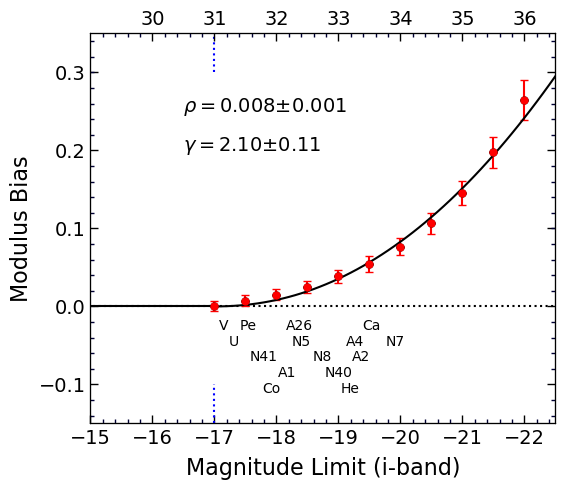

In [13]:
def biasFuc2(M, a, b):
    return a*(np.abs(M-Mlim))**b

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.set_xlim(-16,-23.3)
ax.plot([-12,-24],[0,0], 'k:')

ax.errorbar(M0_C , bias_CM-bias_CM[0], yerr=bias_err_CM*0, fmt='o', color='k', capsize=3, 
            markersize=5, markerfacecolor='white')

ax.errorbar(M0_C , bias_CM0-bias_CM0[0], yerr=bias_err_CM0, fmt='o', color='r', capsize=3, markersize=5)


fit, cov = curve_fit(biasFuc2, M0_C , bias_CM0-bias_CM0[0], sigma=bias_err_CM0)
print fit
print cov

m = np.arange(M0_C[0],-24,-0.1)
ax.plot(m, biasFuc2(m, fit[0], fit[1]), 'k-')
ax.plot([-10, Mlim],[0,0], 'k-')


x_ax, y_ax = set_axes(ax, xlim=(-15,-22.5), ylim=(-0.15,0.35), fontsize=14)
y_ax.set_yticks(np.arange(-0.1, 0.35, step=0.1))
x_ax.set_xlim(31-(-15-Mlim),31-(-15-Mlim)+7.5)
x_ax.set_xticks(np.arange(30,37, 1))
x_ax.set_xticklabels(np.arange(30,37, 1))
x_ax.tick_params(labelsize=14)

ax.set_xlabel('Magnitude Limit', fontsize=16)
ax.set_ylabel('Modulus Bias', fontsize=16)
band_label = band
if band=='w1' or band=='w2':
    band_label = band.upper()
ax.set_xlabel('Magnitude Limit ('+band_label+'-band)', fontsize=16, labelpad=7)


Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.8*Xlm[0]+0.2*Xlm[1]
y0 = 0.2*Ylm[0]+0.8*Ylm[1]
ax.text(x0,y0, r"$\rho = $"+"%.3f" % fit[0]+'$\pm$'+"%.3f" % np.sqrt(cov[0][0]), fontsize=14, color='k')
y0 = 0.3*Ylm[0]+0.7*Ylm[1]
ax.text(x0,y0, r"$\gamma = $"+"%.2f" % fit[1]+'$\pm$'+"%.2f" % np.sqrt(cov[1][1]), fontsize=14, color='k')

ax.plot([Mlim,Mlim], [-0.15,-0.1], 'b:')
ax.plot([Mlim,Mlim], [0.3,1], 'b:')

pos = {}
pos['V'] = -0.02
pos['U'] = -0.04
pos['A26'] = -0.02
pos['Ca'] = -0.02
pos['Pe'] = -0.02
pos['N5'] = -0.04
pos['A4'] = -0.04
pos['N7'] = -0.04
pos['N41'] = -0.06
pos['N8'] = -0.06
pos['A2'] = -0.06
pos['A1'] = -0.08
pos['Co'] = -0.10
pos['N40'] = -0.08
pos['He'] = -0.10


for i, cc in enumerate(code):
    cc = cc.strip()
    if mag_lims[i]>0:
        if param in DM_Dict[cc][band]:
            limit_modulus = mag_lims[i]-DM_Dict[cc][band][param]
            print cc, '%.2f'%limit_modulus, mag_lims[i],DM_Dict[cc][band][param]
            ax.text(limit_modulus, pos[cc]-0.01, cc, fontsize=10, color='k')


0.47223520725407975
V -17.08 13.79 30.87
N7 -19.76 14.8 34.56
A1 -18.02 16.74 34.76
A4 -19.12 15.72 34.84


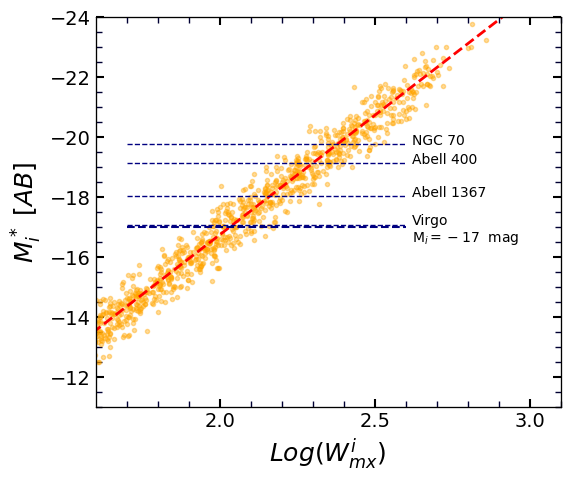

In [14]:
fig, ax = makeFig(band=band, xLim = (1.6,3.1), yLim = (-11,-24), MAGabs=True)
dye = {"u":"blue","g":"green","r":"red","i":"orange","z":"maroon","w1":"purple", 'w2': "brown"}

x = np.linspace(-5,5,50)
y = slope_1*(x-2.5)+zp_1
 
    
bias, simulMag, simulWimx = simulFiled_Mscatter(slope_1, zp_1, Ms, alpha, 
               mag_scatter=rms, size=1000, seed=0)
ax.plot(simulWimx, simulMag, '.', color=dye[band], alpha=0.4)
print np.std(simulMag-(slope_1*(simulWimx-2.5)+zp_1))


ax.plot(x,y, 'r--', lw=2) 

x = np.linspace(1.7,2.6,20)
if band=='u':
    ax.plot(x,-17+(2.68*(x-2.5)+1.58),'--', lw=1.5, color='navy')  
if band=='g':
    ax.plot(x,-17+(0.84*(x-2.5)+0.64),'--', lw=1.5, color='navy')  
if band=='r':
    ax.plot(x,-17+(0.27*(x-2.5)+0.23),'--', lw=1.5, color='navy')  
if band=='i':
    ax.plot(x,-17+(0*(x-2.5)+0),'--', lw=1.5, color='navy') 
    ax.text(2.62, -16.5, 'M'+r'$_i=-17$'+'  mag', fontsize=10, color='k')
if band=='z':
    ax.plot(x,-17-(0.25*(x-2.5)+0.12),'--', lw=1.5, color='navy')          
if band=='w1':
    ax.plot(x,-17-(1.18*(x-2.5)-0.47),'--', lw=1.5, color='k')
    
    
if band=='w2':
    ax.plot(x,-17-(1.32*(x-2.5)-1.04),'--', lw=1.5, color='navy') 
    
    
    
for i, cc in enumerate(code):
    cc = cc.strip()
    if cc in ['V', 'A4', 'N7', 'A1']:
        if mag_lims[i]>0:
            if param in DM_Dict[cc][band]:
                limit_modulus = mag_lims[i]-DM_Dict[cc][band][param]
                print cc, '%.2f'%limit_modulus, mag_lims[i],DM_Dict[cc][band][param]
                ax.plot(x,limit_modulus-x*0,'--', lw=1.0, color='navy')
                
                if cc=='V':
                    ax.text(2.62, limit_modulus, 'Virgo', fontsize=10, color='k')
                elif cc=='A4':
                    ax.text(2.62, limit_modulus, 'Abell 400', fontsize=10, color='k')
                elif cc=='N7':
                    ax.text(2.62, limit_modulus, 'NGC 70', fontsize=10, color='k')            
                elif cc=='A1':
                    ax.text(2.62, limit_modulus, 'Abell 1367', fontsize=10, color='k')      